In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(2017)

In [2]:
def plot_decision_boundary(model, x, y):
    # 找到x, y的最大值和最小值, 并在周围填充一个像素
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # 构建一个宽度为`h`的网格
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 计算模型在网格上所有点的输出值
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # 画图显示
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=np.squeeze(y), cmap=plt.cm.Spectral)

In [3]:
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

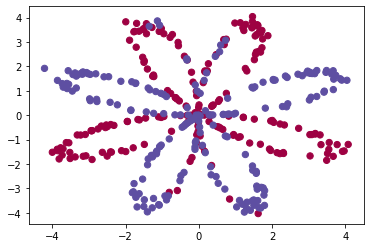

In [4]:
%matplotlib inline

plt.scatter(x[:, 0], x[:, 1], c=np.squeeze(y), s=40, cmap=plt.cm.Spectral)

我们可以先尝试用`logistic`回归模型来解决这个分类问题

In [5]:
x = tf.constant(x, dtype=tf.float32, name='x')
y = tf.constant(y, dtype=tf.float32, name='y')

In [6]:
# 定义模型
w = tf.get_variable(initializer=tf.random_normal_initializer(), shape=(2, 1), dtype=tf.float32, name='weights')
b = tf.get_variable(initializer=tf.zeros_initializer(), shape=(1), dtype=tf.float32, name='bias')

def logistic_model(x):
    logit = tf.matmul(x, w) + b
    
    return tf.sigmoid(logit)

y_ = logistic_model(x)

In [7]:
# 构造训练
loss = tf.losses.log_loss(predictions=y_, labels=y)

lr = 1e-1
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

In [8]:
# 执行训练

sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

for e in range(1000):
    sess.run(train_op)
    if (e + 1) % 100 == 0:
        loss_numpy = loss.eval(session=sess)
        print('Epoch %d: Loss: %.12f' % (e + 1, loss_numpy))

Epoch 100: Loss: 0.673153102398
Epoch 200: Loss: 0.673146009445
Epoch 300: Loss: 0.673146009445
Epoch 400: Loss: 0.673146009445
Epoch 500: Loss: 0.673145890236
Epoch 600: Loss: 0.673146009445
Epoch 700: Loss: 0.673146009445
Epoch 800: Loss: 0.673146009445
Epoch 900: Loss: 0.673146009445
Epoch 1000: Loss: 0.673146009445


看上去`loss`并没有下降, 那么我们再来看看模型的效果

In [9]:
model_input = tf.placeholder(shape=(None, 2), dtype=tf.float32, name='logistic_input')
logistic_output = logistic_model(model_input)

def plot_logistic(x_data):
    y_pred_numpy = sess.run(logistic_output, feed_dict={model_input: x_data})
    out = np.greater(y_pred_numpy, 0.5).astype(np.float32)
    return np.squeeze(out)

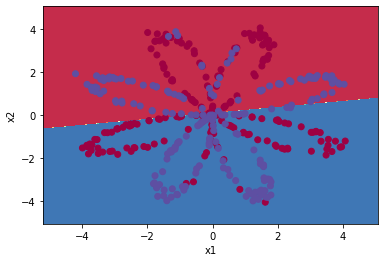

In [10]:
plot_decision_boundary(plot_logistic, x.eval(session=sess), y.eval(session=sess))

## 深度神经网络
现在我们来尝试搭建一个最简单的深度神经网络

In [11]:
# 首先构建第一个隐藏层
with tf.variable_scope('layer1'):
    
    # 构建参数weight
    w1 = tf.get_variable(initializer=tf.random_normal_initializer(stddev=0.01), shape=(2, 4), name='weights1')
    
    # 构建参数bias
    b1 = tf.get_variable(initializer=tf.zeros_initializer(), shape=(4), name='bias1')
    
# 同样地, 我们再构建第二个隐藏层
with tf.variable_scope('layer2'):
    w2 = tf.get_variable(initializer=tf.random_normal_initializer(stddev=0.01), shape=(4, 1), name='weights2')
    b2 = tf.get_variable(initializer=tf.zeros_initializer(), shape=(1), name='bias2')
    
# 通过上面的参数构建一个两层的神经网络
def two_network(nn_input):
    with tf.variable_scope('two_network'):
        # 第一个隐藏层
        net = tf.matmul(nn_input, w1) + b1
        # tanh 激活层
        net = tf.tanh(net)
        # 第一个隐藏层
        net = tf.matmul(net, w2) + b2
        
        # 经过 sigmoid 得到输出
        return tf.sigmoid(net)
    
net = two_network(x)

In [12]:
# 构建神经网络的训练过程
loss_two = tf.losses.log_loss(predictions=net, labels=y, scope='loss_two')

lr = 1

optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss=loss_two, var_list=[w1, w2, b1, b2])

### 模型的保存
在我们开始训练之前, 我们先思考一下, 在之前的过程中, 当模型的参数经过训练之后, 模型的效果得以显示, 而模型的参数却没有得到保存, 那么下次我们希望得到一个比较好的结果的时候, 又必须得重新训练, 这是令人难以接受的.
因此, 我们需要将模型保存到本地, 并且需要一种正确的方式将模型读入到内存中来.

`Tensorflow`提供了`tf.train.Saver`类来管理模型的保存与加载

In [13]:
saver = tf.train.Saver()

接着, 在我们训练的过程中, 随时可以调用`saver`的`save`函数去保存中间过程的参数, 它会把模型存放在`.ckpt`文件中

下面我们试着对这个模型训练10000次, 并且在第5000步以及最后一步各保存一次模型

In [14]:
# 我们训练10000次

sess.run(tf.global_variables_initializer())

for e in range(10000):
    sess.run(train_op)
    if (e + 1) % 1000 == 0:
        loss_numpy = loss_two.eval(session=sess)
        print('Epoch {}: Loss: {}'.format(e + 1, loss_numpy))
    if (e + 1) % 5000 == 0:
        # `sess`参数表示开启模型的`session`, 必选参数
        # `save_path`参数表示模型保存的路径, 必须要以`.ckpt`结尾
        # `global_step`参数表示模型当前训练的步数, 可以用来标记不同阶段的模型
        saver.save(sess=sess, save_path='First_Save/model.ckpt', global_step=(e + 1))

Epoch 1000: Loss: 0.28517913818359375
Epoch 2000: Loss: 0.2722324728965759
Epoch 3000: Loss: 0.2651161849498749
Epoch 4000: Loss: 0.2602877914905548
Epoch 5000: Loss: 0.25684040784835815
Epoch 6000: Loss: 0.25428810715675354
Epoch 7000: Loss: 0.25233837962150574
Epoch 8000: Loss: 0.2508088946342468
Epoch 9000: Loss: 0.24958162009716034
Epoch 10000: Loss: 0.2485777884721756


现在, 进入到`First_Save`目录中, 应该会看到下面这些内容:
```
First_Save/
├── checkpoint
├── model.ckpt-10000.data-00000-of-00001
├── model.ckpt-10000.index
├── model.ckpt-10000.meta
├── model.ckpt-5000.data-00000-of-00001
├── model.ckpt-5000.index
└── model.ckpt-5000.meta
```

可以看到, `model.ckpt-5000`和`model.ckpt-10000`都是保存好的模型, 而他们又都有`.data-00000-of-00001`, `.meta`和`.index`三个文件. 这是由于`tensorflow`在保存的过程中同时保存了模型的定义和模型参数的值, 然后又分开不同的文件存放, 以后我们会具体谈到如何应用这三个文件, 暂时我们只需要理解`model.ckpt-***`就是我们保存好的模型就行了

训练完成之后, 我们先看一下模型训练的效果如何

In [15]:
nn_out = two_network(model_input)

def plot_network(input_data):
    y_pred_numpy = sess.run(nn_out, feed_dict={model_input: input_data})
    out = np.greater(y_pred_numpy, 0.5).astype(np.float32)
    return np.squeeze(out)

Text(0.5, 1.0, '2 layer network')

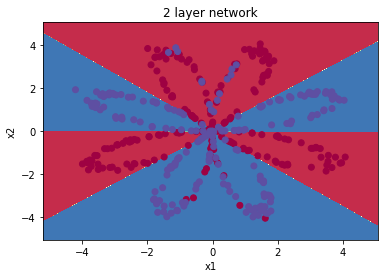

In [16]:
plot_decision_boundary(plot_network, x.eval(session=sess), y.eval(session=sess))
plt.title('2 layer network')

可以看到, 2层神经网络的效果明显优于`logistic`回归的效果.

那么接下来我们再看看如何从本地导入模型以及参数

In [17]:
# 首先关闭当前会话
sess.close()

现在重新打开一个session, 会如何呢?

In [18]:
sess = tf.InteractiveSession()

# 用try语句打印一下`w1`的值
try:
    print(w1.eval(session=sess))
except tf.errors.FailedPreconditionError as e:
    print(e.message)

Attempting to use uninitialized value layer1/weights1
	 [[Node: layer1/weights1/_0 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_layer1/weights1", _device="/job:localhost/replica:0/task:0/device:GPU:0"](layer1/weights1)]]
	 [[Node: layer1/weights1/_1 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_layer1/weights1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


对, 没错, 恭喜你遇到了本教程中第一个报错. 但是没有补偿, 因为我们确实没有初始化参数的值. 但是, 如果我们用`tf.global_variables_initializer()`这一类函数去初始化的话, 之前训练好的模型参数就是无用功了, 这种事情当然可以避免了

### 模型的恢复
加载模型也叫做模型的恢复, 包括两个阶段
- 首先, 恢复模型的结构
- 再恢复模型的参数值

In [19]:
# 恢复模型结构
saver = tf.train.import_meta_graph('First_Save/model.ckpt-10000.meta')

# 恢复模型参数
saver.restore(sess, 'First_Save/model.ckpt-10000')

INFO:tensorflow:Restoring parameters from First_Save/model.ckpt-10000


In [20]:
# 打印一下`w1`的值
print(w1.eval(session=sess))

[[-10.30079     10.045415     0.04463813   0.5395567 ]
 [ 12.908468    11.74965      7.9305696    1.9521588 ]]


Text(0.5, 1.0, '2 layer network')

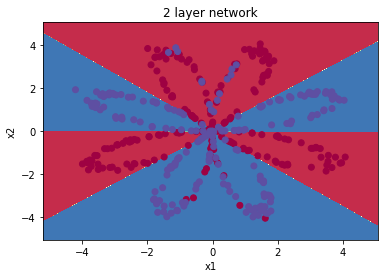

In [21]:
# 重新可视化一下分类结果
plot_decision_boundary(plot_network, x.eval(session=sess), y.eval(session=sess))
plt.title('2 layer network')

好了, 我们终于实现了模型的加载, 终于可以放心的存取模型了!

### 练习
试着用5层神经网络,改变学习率,增加训练次数, 看看它的效果

### 参考答案

In [22]:
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None):
    # 探索一下这里面的`reuse`参数有什么用
    # 在后面的课程中会讲到
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        w = tf.get_variable(initializer=tf.random_normal_initializer(), shape=(input_depth, output_depth), name='weights')
        b = tf.get_variable(initializer=tf.zeros_initializer(), shape=(output_depth), name='bias')
        net = tf.matmul(layer_input, w) + b
        
        return net

def DNN(x, output_depths, scope='DNN', reuse=None):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d' % i, reuse=reuse)
        net = tf.tanh(net)
    net = hidden_layer(net, 1, scope='classification', reuse=reuse)
    net = tf.sigmoid(net)
    
    return net

In [23]:
dnn = DNN(x, [10, 10, 10])

In [24]:
loss_dnn = tf.losses.log_loss(predictions=dnn, labels=y)

lr = 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss_dnn)

In [25]:
# 我们训练10000次

sess.run(tf.global_variables_initializer())

for e in range(20000):
    sess.run(train_op)
    if (e + 1) % 1000 == 0:
        loss_numpy = loss_dnn.eval(session=sess)
        print('Epoch {}: Loss: {}'.format(e + 1, loss_numpy))

Epoch 1000: Loss: 0.19023920595645905
Epoch 2000: Loss: 0.17365024983882904
Epoch 3000: Loss: 0.16063526272773743
Epoch 4000: Loss: 0.1504669189453125
Epoch 5000: Loss: 0.1437441110610962
Epoch 6000: Loss: 0.13819199800491333
Epoch 7000: Loss: 0.13095596432685852
Epoch 8000: Loss: 0.12652777135372162
Epoch 9000: Loss: 0.1300041526556015
Epoch 10000: Loss: 0.12292575091123581
Epoch 11000: Loss: 0.11895758658647537
Epoch 12000: Loss: 0.11944964528083801
Epoch 13000: Loss: 0.11564227938652039
Epoch 14000: Loss: 0.11820860207080841
Epoch 15000: Loss: 0.11228327453136444
Epoch 16000: Loss: 0.11168020218610764
Epoch 17000: Loss: 0.1106533408164978
Epoch 18000: Loss: 0.1167072206735611
Epoch 19000: Loss: 0.10839433968067169
Epoch 20000: Loss: 0.10785578936338425


In [26]:
dnn_out = DNN(model_input, [10, 10, 10], reuse=True)

def plot_dnn(input_data):
    y_pred_numpy = sess.run(dnn_out, feed_dict={model_input: input_data})
    out = np.greater(y_pred_numpy, 0.5).astype(np.float32)
    return np.squeeze(out)

Text(0.5, 1.0, '4 layer network')

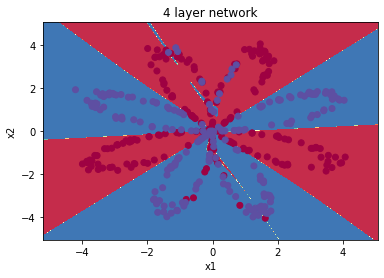

In [27]:
# 重新可视化一下分类结果
plot_decision_boundary(plot_dnn, x.eval(session=sess), y.eval(session=sess))
plt.title('4 layer network')

### 结语
回顾一下, 这次课我们主要讲述了深度神经网络的基本原理以及`tensorflow`中如何实现模型的保存与加载, 在下一次课中, 我们将会介绍如何使用更深的神经网络来解决更复杂的分类问题